In [3]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import cmath
import time 
import copy
class GS_synthesis(object):
    
    def __init__(self,  holo_pixel_size, distance, wavelength, input_matrix_size, error, iter_limit, img_size_for_syn = None):
        
        self.name = 'Gerchberg_Sexton'
        self._first_frenel_factor = None
        self._second_frenel_factor = None
        self._first_inv_frenel_factor = None
        self._second_inv_frenel_factor = None
        self.holo_pixel_size = holo_pixel_size
        self.distance = distance
        self.wavelength = wavelength
        self.input_matrix_size = input_matrix_size 
        self.error = error
        self.iter_limit = iter_limit 
        self.error_lists = []
        self.img_pixel_size = self.wavelength * self.distance / (self.input_matrix_size * self.holo_pixel_size)
        self.scale = self.img_pixel_size / self.holo_pixel_size
        
        if img_size_for_syn  is None:
            self.img_size_for_syn = self.input_matrix_size - int(self.input_matrix_size/2)
        elif self.input_matrix_size % self.reshape_img_size != 0:
            print("Некорректный ввод  нового размера изображения, исходный размер  должен делиться на него без остатка")
            exit()
        else: self.img_size_for_syn = img_size_for_syn
            
                
    def reshape_img_for_syn(self, input_matrix):
        print(self.img_size_for_syn)
        new_img = np.zeros((self.input_matrix_size, self.input_matrix_size))
        reshape_img = cv2.resize(input_matrix, (self.img_size_for_syn,self.img_size_for_syn))
        index = int((self.input_matrix_size - self.img_size_for_syn) / 2)
        new_img[index:index + self.img_size_for_syn, index:index + self.img_size_for_syn] = reshape_img
        self.reshape_img = reshape_img
        self.new_img = new_img
        return new_img

    def matrix_normalization(self, input_matrix):
        norm_matrix = np.zeros((self.input_matrix_size, self.input_matrix_size)) 
        for i in range (self.input_matrix_size):
            for j in range (self.input_matrix_size):
                element = cmath.phase(input_matrix[i,j])
                if element < 0:
                    element = 2 * np.pi + element
                element = element/(2 * np.pi) * 256
                norm_matrix[i,j] = element
        return norm_matrix.astype('uint8')

        
    

    @property
    def first_frenel_factor(self):
        if self._first_frenel_factor is None:
            self._first_frenel_factor = (
                np.exp(
                    np.array([
                        [
                            1j * np.pi * self.scale * ((i- int(self.input_matrix_size / 2))**2 + (j - int(self.input_matrix_size / 2))**2) / self.input_matrix_size
                            for j in range(self.input_matrix_size)
                        ]
                        for i in range(self.input_matrix_size)
                    ])
                )
            ) 

        return self._first_frenel_factor

    @property
    def second_frenel_factor(self):
        if self._second_frenel_factor is None:
            self._second_frenel_factor = (
                np.exp(
                    np.array([
                        [
                            1j * np.pi * ((i- int(self.input_matrix_size / 2))**2 + (j - int(self.input_matrix_size / 2))**2) / (self.input_matrix_size * self.scale)
                                   for j in range(self.input_matrix_size)
                        ] 
                        for i in range(self.input_matrix_size)
                    ])
                )
            )
        return self._second_frenel_factor
      
    @property
    def first_inv_frenel_factor(self):
        if self._first_inv_frenel_factor is None:
            self._first_inv_frenel_factor = np.exp(
                np.array([
                    [
                        -1j * np.pi * ((i- int(self.input_matrix_size / 2))**2 + (j - int(self.input_matrix_size / 2))**2)/(self.scale * self.input_matrix_size)
                        for j in range(self.input_matrix_size)
                    ]
                    for i in range(self.input_matrix_size)
                ])
            )
        return self._first_inv_frenel_factor

    @property
    def second_inv_frenel_factor(self):
        if self._second_inv_frenel_factor is None:
            self._second_inv_frenel_factor = np.exp(
                np.array([
                    [
                        -1j * np.pi * self.scale *  ((i - int(self.input_matrix_size / 2))**2 + (j - int(self.input_matrix_size / 2))**2) / (self.input_matrix_size)
                        for j in range(self.input_matrix_size)
                    ]
                    for i in range(self.input_matrix_size)
                ])
            )
            

        return self._second_inv_frenel_factor

    def frenel_transform(self,input_matrix):
        fourier = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(input_matrix * self.first_frenel_factor)))
        return  self.second_frenel_factor * fourier
    
    def inverse_frenel_transform(self,input_matrix):
        inv_fourier = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(input_matrix * self.first_inv_frenel_factor)))
        return self.second_inv_frenel_factor * inv_fourier
    
    
    def initial_approx(self):
        return np.exp(1j * np.random.rand(self.input_matrix_size, self.input_matrix_size))
    
    def prepare_for_frenel (self, input_matrix):
        return np.exp(1j * input_matrix * 2 * np.pi / 255)

    def calc_error(self, input_matrix, real_img):
        input_matrix = np.float64(abs(input_matrix))
        real_img = np.float64(abs(real_img))
        a = np.sum(input_matrix**2)
        b = np.sum(real_img**2)
        ab = np.sum(input_matrix*real_img)
        return np.sqrt(1-(ab*ab)/(a*b))

    def img_recovery(self, holo):
        rec_img = abs(self.frenel_transform(self.prepare_for_frenel(holo)))
        self.recovery_img  = rec_img   
        index = int((self.input_matrix_size - self.img_size_for_syn) / 2)
        informative_img_zone = rec_img[index:index + self.img_size_for_syn, index:index + self.img_size_for_syn]
        self.informative_img_zone = informative_img_zone
        
    def __call__(self, input_matrix):
        error_list = []
        start_time = time.time()
        holo = self.initial_approx()
        img = self.reshape_img_for_syn(input_matrix)
        error = float('inf')
        i = 0
        while error > self.error and i < self.iter_limit:
            ref_img = self.frenel_transform(holo)
            error = self.calc_error(ref_img, img)
            ref_img = np.sqrt(img) * np.exp(1j*np.angle(ref_img))
            holo = self.inverse_frenel_transform(ref_img)
            holo = np.exp(1j*np.angle(holo))
            i += 1 
            error_list.append(error)
            print("Iteration ", i, "error ", error)
            
        self.iteration = i
        self.error_lists.append(error_list)
        holo = self.matrix_normalization(holo)
        self.img_recovery(holo)
        self.holo = holo
        print("--- %s seconds ---" % (time.time() - start_time))
        return holo



In [4]:
img_1 = cv2.imread("C:\\Users\\minik\\Desktop\\timur_4.jpg", cv2.IMREAD_GRAYSCALE)
img_2 = cv2.imread("C:\\Users\\minik\\Desktop\\1.bmp", cv2.IMREAD_GRAYSCALE)
img_3 = cv2.imread("C:\\Users\\minik\\Desktop\\hello.jpg", cv2.IMREAD_GRAYSCALE)

In [5]:
transform = GS_synthesis(
    holo_pixel_size = 8e-6,
    distance = 0.5,
    wavelength = 532e-9,
    input_matrix_size = 512,
    error = 1e-9,
    iter_limit = 20
)

In [16]:
img = transform.frenel_transform(img_2)

True

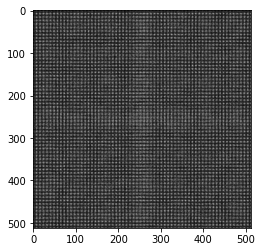

In [17]:
plt.imshow(abs(img), cmap = 'gray')
plt.show
img = abs(img)*255/abs(img).max()
cv2.imwrite("C:\\Users\\minik\\Desktop\\3.bmp", img)

512
Iteration  1 error  0.9348423372354832
Iteration  2 error  0.5793236283875733
Iteration  3 error  0.4859773829043345
Iteration  4 error  0.45064206164273235
Iteration  5 error  0.43263313761168487
Iteration  6 error  0.4214327205642365
Iteration  7 error  0.4135917385781591
Iteration  8 error  0.4077095526720885
Iteration  9 error  0.4030881913577773
Iteration  10 error  0.39933887627031844
Iteration  11 error  0.3962094546574089
Iteration  12 error  0.3935443326095347
Iteration  13 error  0.39123654730102664
Iteration  14 error  0.3892133076887461
Iteration  15 error  0.38741851962944235
Iteration  16 error  0.3858131895479703
Iteration  17 error  0.3843681162846437
Iteration  18 error  0.3830556540264793
Iteration  19 error  0.38185484586450824
Iteration  20 error  0.3807534104524039


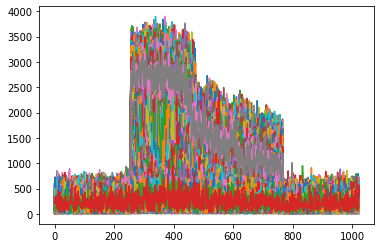

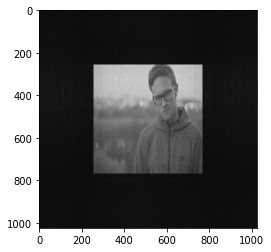

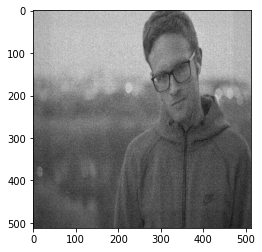

--- 13.118055820465088 seconds ---


In [32]:

holo = transform(img_2)

In [29]:
def show_error(class_obj, last_img = True):
    error_lists = class_obj.error_lists
    
    if last_img:
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(1,1,1)
        ax.plot(np.array(error_lists[-1]), '-o')
        ax.grid()
        ax.set_xlabel('Iteration',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=24)
        ax.set_ylabel("NSKD",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=24)
    else:
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(1,1,1)
        for errors in error_lists:
            ax.plot(np.array(errors),'-o')
        ax.grid()
        ax.set_xlabel('Iteration',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=24)
        ax.set_ylabel("NSKD",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=24)
        

In [23]:
holo_2 = transform(img_2)

Iteration  1 error  0.9329931305607085
Iteration  2 error  0.565636056575232
Iteration  3 error  0.4794227543452118
Iteration  4 error  0.4474866752794219
Iteration  5 error  0.43085843946004454
Iteration  6 error  0.42034738730551485
Iteration  7 error  0.41295169925833614
Iteration  8 error  0.40741327467022326
Iteration  9 error  0.4030700774555143
Iteration  10 error  0.3995418638248844
Iteration  11 error  0.39660004225901735
Iteration  12 error  0.39409983870456883
Iteration  13 error  0.39193885627527475
Iteration  14 error  0.39004392475640565
Iteration  15 error  0.3883588981404178
Iteration  16 error  0.38684661032305506
Iteration  17 error  0.385479835041885
Iteration  18 error  0.38423692263042863
Iteration  19 error  0.38310093168671205
Iteration  20 error  0.3820587801011265
Iteration  21 error  0.38109868865003876
Iteration  22 error  0.3802099402997689
Iteration  23 error  0.3793835244537459
Iteration  24 error  0.37861126472969214
Iteration  25 error  0.377887224082349

In [27]:
holo_3 = transform(img_3)

Iteration  1 error  0.9072876842273476
Iteration  2 error  0.513220943419372
Iteration  3 error  0.4012837427187179
Iteration  4 error  0.3547712804318901
Iteration  5 error  0.3316897103894734
Iteration  6 error  0.31759983712329765
Iteration  7 error  0.3078538089248657
Iteration  8 error  0.3006148499347423
Iteration  9 error  0.2949562976244907
Iteration  10 error  0.29036306285049673
Iteration  11 error  0.2865342805969506
Iteration  12 error  0.2832841824174492
Iteration  13 error  0.2804887459246517
Iteration  14 error  0.27805494293010513
Iteration  15 error  0.2759108549688661
Iteration  16 error  0.27400434706516635
Iteration  17 error  0.2722964661398341
Iteration  18 error  0.27075595968216415
Iteration  19 error  0.26935845906120043
Iteration  20 error  0.2680833816619604
Iteration  21 error  0.26691263559648987
Iteration  22 error  0.26583263988414063
Iteration  23 error  0.2648323222093809
Iteration  24 error  0.2639017492451782
Iteration  25 error  0.2630324376609662
It